In [1]:
import os
import matplotlib.pyplot as plt 
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy import constants as const

from astropy.convolution import convolve_fft

from astropy.modeling.models import BlackBody
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
import glob

from astropy.visualization import simple_norm
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
import matplotlib.cm as cm
from astropy import constants as sc
from webbpsf_ext import image_manip
import subprocess

/var/folders/hv/sqhlym89251brwhx_6w2mmrc0005n_/T/ipykernel_15076/2746481639.py:11: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
/var/folders/hv/sqhlym89251brwhx_6w2mmrc0005n_/T/ipykernel_15076/2746481639.py:11: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


# step 1: make noise annulus image

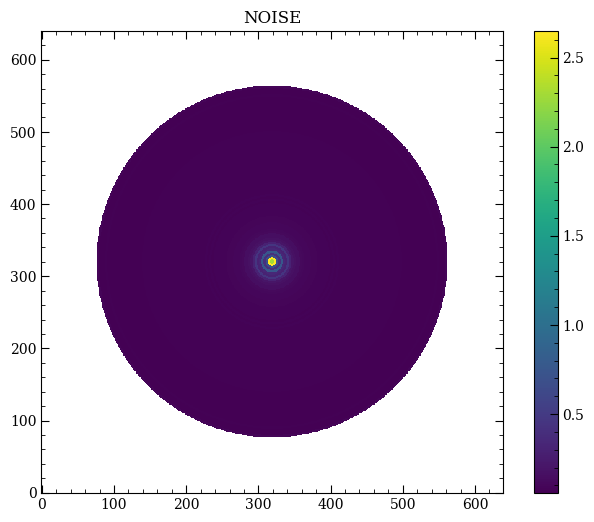

In [2]:

datadir = '/Users/sbetti/Documents/Science/datasets/JWST/49Ceti_NIRCam/'
noise = fits.getdata(datadir + 'background/klipsub/BKG_RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASKA335R_SUB320A335R-KLmodes-all.fits')[0,:,:]

xx = noise.shape[1]
yy = noise.shape[0]
y,x = np.mgrid[:yy, :xx]

plt.figure()
real_noise = np.zeros_like(noise)
for R in np.arange(0,xx,3):
    circ1 = ((x - 319.5)**2.) + ((y-319.5)**2.) > R**2.
    circ2 = ((x - 319.5)**2.) + ((y-319.5)**2.) <= (R+3)**2.

    circ = circ2&circ1
    std = np.nanstd(noise[circ])
    real_noise[circ] = std

plt.imshow(real_noise)
plt.title('NOISE')
plt.colorbar()
plt.show()
hdr = fits.getheader(datadir + 'background/klipsub/BKG_RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASKA335R_SUB320A335R-KLmodes-all.fits')

noise = fits.writeto(datadir + 'background/klipsub/BKG_STD_RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASKA335R_SUB320A335R-KLmodes-all.fits',
                    real_noise, header=hdr,overwrite=True)


# STEP 2: create MCFOST .para file

# STEP 3: run MCFOST .para file

In [3]:
cd ../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/

/Users/sbetti/Documents/Science/DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files


In [4]:
mod = f'49Ceti_mcfost_F444W_params.para'

In [5]:
# run mcfost to create scattered light image
subprocess.call(f'mcfost {mod} -img 4.44 -only_scatt >> 49Ceti_mcfost_F444W_imagemcfostout.txt', shell = True)
    

0

In [6]:
cd ../../../../../Disk_DiffEvo/

/Users/sbetti/Documents/Science/Disk_DiffEvo


# STEP 4: load model and convolve with PSF

In [7]:
import disk_convolution as dc
%load_ext autoreload
%autoreload 2

In [8]:
model_gz = '../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/data_4.44/RT.fits.gz'

In [9]:
# get mcfost pixel scale
modelpixelscale = fits.getheader(model_gz)['CDELT2'] * 3600
modelpixelscale

0.063928872

In [10]:
WAVELENGTH = 4.44
DISTANCE_STAR = 57.23
FILTER = 'F444W'
obsdate='2023-08-24T22:49:38.762'
grid_shape='circle'
ROLL_REF_ANGLE  = 263.999370671002
OBJ_INFO = {
  'name': '49 Ceti',
  'sptype': 'A0V', 
  'Teff': 9000, 
  'log_g': 4.0,
  'metallicity': -0.5, 
  'dist': 57.23,
  'flux': 5.458,
  'flux_units': 'vegamag',
  'bp_ref': "bp_2mass('k')",
  'RA_obj': 36.48744,  
  'Dec_obj':  -12.29054}  



In [11]:
# this can take a long time if the webbpsf images are not already made
inst, tel_point, obj_params = dc.make_psfs(ROLL_REF_ANGLE, OBJ_INFO, FILTER, obsdate=obsdate)


  --> starting make_psfs
[   webbpsf:INFO] NIRCam aperture name updated to NRCA1_FULL
[   webbpsf:INFO] NIRCam pupil mask setter: aperturename NRCA1_FULL
[   webbpsf:INFO] NIRCam aperture name updated to NRCA2_FULL_WEDGE_RND
[   webbpsf:INFO] NIRCam aperture name updated to NRCA5_FULL_MASK335R
[   webbpsf:INFO] NIRCam aperture name updated to NRCA5_MASK335R
[webbpsf_ext:INFO] Loading /Users/sbetti/data/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_F444W_CIRCLYOT_MASK335R_pix320_os2_jsig1_r0.00_th+0.0_OPD-2022-07-30_siwfe_distort_legendre.fits
[webbpsf_ext:INFO] Loading /Users/sbetti/data/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_F444W_CIRCLYOT_MASK335R_pix256_os2_jsig1_r0.00_th+0.0_OPD-2022-07-30_siwfe_distort_legendre_large_grid_wfemask.npz
iterating query, tdelta=3.0

MAST OPD query around UTC: 2023-08-24T22:49:38.762
                        MJD: 60180.9511430787

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2023082301-NRCA3_FP1-1.fits
	Date (MJD):	 60179.0914
	Delta

In [12]:
hdul_psfs = dc.make_psfgrid(inst, tel_point, grid_shape=grid_shape)


  --> starting make_psfgrid


PSFs:   0%|          | 0/64 [00:00<?, ?it/s]

In [13]:
model_here_convolved = dc.convolve_disk(inst, tel_point, obj_params, hdul_psfs, model_gz, modelpixelscale,
                                        WAVELENGTH, DISTANCE_STAR,
                                       verbose=True)


writing convolved image to:  ../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/data_4.44/RT_model_NRCA5_MASK335R_F444W_mJyas2.fits


# STEP 5: rename and move to initialize_files folder

In [14]:
old_fil = '../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/data_4.44/RT_model_NRCA5_MASK335R_F444W_mJyas2.fits'
new_fil = '../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/49Ceti_NRCALONG_MASK335R_F444W_FirstModelConvolved.fits'
import shutil

shutil.move(old_fil, new_fil)



'../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/49Ceti_NRCALONG_MASK335R_F444W_FirstModelConvolved.fits'

# STEP 6: make klbasis.h5 file

In [2]:
import pyklip.rdi as rdi

# Import the JWST class from spaceKLIP
import spaceKLIP
from spaceKLIP import database, coron1pipeline, coron2pipeline, coron3pipeline, pyklippipeline, imagetools

from pyklip.fmlib.diskfm import DiskFM
import pyklip.fm as fm

%load_ext autoreload
%autoreload 2

In [3]:
datadir = '/Users/sbetti/Documents/Science/datasets/JWST/'
output_dir = datadir + '49Ceti_NIRCam/spaceklip_2rolls/'

In [4]:
scifiles1 = glob.glob(datadir + '49Ceti_NIRCam/spaceklip_2rolls/padded/*9001_*nrca2_calints.fits')
scifiles2 = glob.glob(datadir + '49Ceti_NIRCam/spaceklip_2rolls/padded/*10001_*nrca2_calints.fits')
scifiles = scifiles1 + scifiles2
scifiles

# scifiles1 = glob.glob(datadir + '49Ceti_NIRCam/spaceklip_2rolls/padded/*9001_*nrcalong_calints.fits')
# scifiles2 = glob.glob(datadir + '49Ceti_NIRCam/spaceklip_2rolls/padded/*10001_*nrcalong_calints.fits')
# scifiles = scifiles1 + scifiles2
# scifiles

['/Users/sbetti/Documents/Science/datasets/JWST/49Ceti_NIRCam/spaceklip_2rolls/padded/jw01563009001_03106_00001_nrca2_calints.fits',
 '/Users/sbetti/Documents/Science/datasets/JWST/49Ceti_NIRCam/spaceklip_2rolls/padded/jw01563010001_03106_00001_nrca2_calints.fits']

In [5]:
psffiles = np.sort(glob.glob(datadir + '49Ceti_NIRCam/spaceklip_2rolls/padded/*nrca2_calints.fits'))
IND = np.where((psffiles != scifiles[0]) &(psffiles != scifiles[1]) )
psffiles = list(psffiles[IND])

# psffiles = np.sort(glob.glob(datadir + '49Ceti_NIRCam/spaceklip_2rolls/padded/*nrcalong_calints.fits'))
# IND = np.where((psffiles != scifiles[0]) &(psffiles != scifiles[1]) )
# psffiles = list(psffiles[IND])


In [6]:
Database = database.Database(output_dir=output_dir)

In [7]:
Database.read_jwst_s012_data(datapaths=scifiles,
                                 psflibpaths=psffiles,
                                 bgpaths=None)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCA2_F200W_MASKRND_MASKA335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ...  PIXSCALE BUNIT       ROLL_REF      BLURFWHM
---- --------- -------- -------- ... --------- ------ ------------------ --------
 SCI NRC_CORON   STAGE2     JWST ... 0.0306955 MJy/sr  264.1780360873808      nan
 SCI NRC_CORON   STAGE2     JWST ... 0.0306955 MJy/sr 274.17916204507975      nan
 REF NRC_CORON   STAGE2     JWST ... 0.0306955 MJy/sr  261.5260546934783      nan
 REF NRC_CORON   STAGE2     JWST ... 0.0306955 MJy/sr 261.52606495514704      nan
 REF NRC_CORON   STAGE2     JWST ... 0.0306955 MJy/sr 261.52604844070214      nan
 REF NRC_CORON   STAGE2     JWST ... 0.0306955 MJy/sr 261.52608329008956      nan
 ...       ...      ...      ... ...       ...    ...                ...      ...
 REF NRC_CORON   STAGE2     JWST ... 0.0306955 MJy/sr  78.05255036534989      nan
 REF NRC_CORON   

In [8]:
# Database.obs.keys()
key = 'JWST_NIRCAM_NRCA2_F200W_MASKRND_MASKA335R_SUB320A335R'
# key = 'JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASKA335R_SUB320A335R'


In [9]:
dataset = pyklippipeline.SpaceTelescope(Database.obs[key], 
                         scifiles, psffiles)

In [10]:
# FirstConvolvedModel
new_fil = '../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/49Ceti_NRCA2_MASK335R_F200W_FirstModelConvolved.fits'

# new_fil = '../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/49Ceti_NRCALONG_MASK335R_F444W_FirstModelConvolved.fits'
disk_model_convolved = fits.getdata(new_fil)
disk_model_convolved = np.pad(disk_model_convolved, 160)
disk_model_convolved.shape

(640, 640)

In [14]:
basis_filename = '../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/49Ceti_NRCA2_MASK335R_F200W_klbasis-2.h5'
# basis_filename = '../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/49Ceti_NRCALONG_MASK335R_F444W_klbasis-2.h5'

diskobj = DiskFM(dataset.input.shape, [3], dataset, disk_model_convolved,
                aligned_center=[319.5, 319.5], 
                 basis_filename = basis_filename, 
                 save_basis = True)

In [15]:
fileprefix = "FM_200W"
# fileprefix = "FM_444W"
fm.klip_dataset(dataset, diskobj, outputdir="../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/", 
                fileprefix=fileprefix,
                numbasis=[3], maxnumbasis=261, aligned_center=[319.5, 319.5], movement=1,
                mode='RDI', annuli=1, subsections=1, psf_library=dataset.psflib, 
               time_collapse='mean')

Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 90258.62602975652 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
saving
Writing KLIPed Images to directory /Users/sbetti/Documents/Science/DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files


In [ ]:
diskobj = DiskFM(None, [3], None,
                disk_model_convolved, aligned_center=[319, 319],
                basis_filename=basis_filename, load_from_basis=True)

In [26]:
# clean up FM disk that were produced
fils = glob.glob('../DebrisDisks/49Ceti/disk_modeling/DiffEvo/initialize_files/FM_*KLmodes-all.fits')
for f in fils:
    os.remove(f)

# STEP 7: make mask for chi2

In [ ]:
# datadir = '/Users/sbetti/Documents/Science/datasets/JWST/49Ceti_NIRCam/spaceklip_2rolls/klipsub'
# REDUCED_DATA = fits.getdata(datadir + '/RDI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASKA335R_SUB320A335R-KLmodes-all.fits')[2]

# sigma= 4
# levels=[0.0869344] #[0.005]

# # make mask image for chi2 calculation
# result = gaussian_filter(REDUCED_DATA, sigma=sigma)  # Round 4 used sigma=4
# plt.figure()
# plt.imshow(REDUCED_DATA, vmin=0, vmax=0.83)
# cs = plt.contour(result, levels=levels, colors='white', zorder=100, linewidths=1)
# verts = cs.collections[0].get_paths()[0]
# mask = verts.contains_points(list(np.ndindex(result.shape)))
# mask = mask.reshape(result.shape).T
# MASK = np.logical_not(mask)
# plt.imshow(MASK)
# plt.colorbar()
# plt.xlim(120,500)
# plt.ylim(120,500)
# plt.show()
# print(MASK)
# fits.writeto('initialize_files/49Ceti_NRCALONG_MASK335R_F444W_MASK.fits', MASK*1, overwrite=True)